In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import caffe
import logging
import numpy as np
import pickle
import pycuda.driver as cuda
import pycuda.autoinit
import uff
import tensorrt as trt
import ctypes

from matplotlib import pyplot as plt
from six.moves import cPickle
import time
import tensorflow as tf
import logging


In [14]:
def load_CIFAR10_dataset(file_name):
    with open(file_name, 'rb') as f:                
        d = cPickle.load(f)
        # decode utf8
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode('utf8')] = v
        d = d_decoded
        data = d['data']
        labels = d['labels']
        raw_float_data = np.array(data, dtype=float) 
        return raw_float_data, labels
    
def mAP(y_true, y_pred):
    
    y_true = np.array(labels).astype(np.int64)
    y_true = tf.identity(y_true)

    y_pred = np.array(y_pred).astype(np.float32)
    y_pred = tf.identity(y_pred) # np to tensor
    _, m_ap = tf.metrics.average_precision_at_k(y_true, y_pred, 1)
    sess = tf.Session()
    sess.run(tf.local_variables_initializer())
    tf_map = sess.run(m_ap)
    return tf_map


def rgbToBgr(img):

    return np.transpose(img, (2, 1, 0))

def swapImgsChannels(imgs):
    for i in range(0, len(imgs)):
        temp =  imgs[i, 0]
        imgs[i, 0] = imgs[i, 2]
        imgs[i, 2] = temp;
    return imgs;
    

In [15]:
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
logging.debug("test")
caffe.set_device(0) 
caffe.set_mode_gpu()





In [16]:
net = caffe.Net('/home/vtpc/Documents/Alvils/tensorrt/pretrained-models/cifar-10-googlenet/deploy.prototxt',
                '/home/vtpc/Documents/Alvils/tensorrt/pretrained-models/cifar-10-googlenet/weights.caffemodel',
                caffe.TEST)
cifar_file = "/home/vtpc/Documents/Alvils/tensorrt/data/cifar10/test_batch"


In [17]:
mu = np.load( "/home/vtpc/Documents/Alvils/tensorrt/pretrained-models/cifar-10-googlenet/mean.npy" )
#mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
# create transformer for the input called 'data'
#transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
##transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
#transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
#transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
#transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)


print(mu.shape)

mean-subtracted values: [('B', 125.30691780149937), ('G', 122.9503942579031), ('R', 113.86538316309452)]
(3,)


(10000, 3, 32, 32)
(10000, 3, 32, 32)


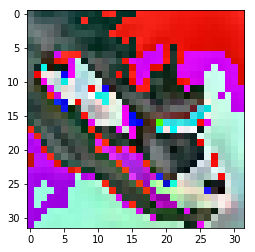

In [18]:
batch_size = 450
imgs, labels = load_CIFAR10_dataset(cifar_file)
transformed_imgs = imgs.reshape([-1, 3, 32, 32]).astype("uint8")

print(transformed_imgs.shape)
new_ims = transformed_imgs

#new_ims = swapImgsChannels(new_ims)#.transpose([0, 3, 2, 1])#np.zeros((im_shape[0], im_shape[3], im_shape[2], im_shape[1]))
plt.imshow(np.transpose(new_ims[15],(1,2,0)))
for i in range(0, len(new_ims)):
    new_ims[i][0] = new_ims[i][0] - mu[0]
    new_ims[i][1] = new_ims[i][1] - mu[1]
    new_ims[i][2] = new_ims[i][2] - mu[2]

plt.imshow(np.transpose(new_ims[15],(1,2,0)))

#for i in range(0, len(transformed_imgs)):
#    new_ims[i] = transformer.preprocess('data', transformed_imgs[i])
#print("a")
print(new_ims.shape)
max_batches = ((len(transformed_imgs) // batch_size) + (1 if (len(transformed_imgs) % batch_size) else 0))



In [20]:
results = []
current = 0
t0 = time.time()     
for i in range(0, max_batches):
    current = i * batch_size;
    next_ind = 0;
    imgs_ravel = [];
    if (i+1 == max_batches):
        next_ind = i * batch_size  + len(new_ims) - i * batch_size
    else:
        next_ind = (i + 1) * batch_size
    current_batch_size = next_ind - current;
    imgs_ravel = new_ims[current : next_ind]    
    net.blobs['data'].reshape(current_batch_size, 3, 32, 32)
    for j in range(0, current_batch_size):
        net.blobs['data'].data[j,:,:,:] = imgs_ravel[j]
    output = net.forward()
    results = np.append(results, output['loss3/classifier'])
results1 = results.reshape(-1, 10)
pred = mAP(labels, results1)
print(pred)
    

0.273


In [ ]:
list_a = [1, 2, 3]
list_b = ['a', 'b', 'c', 'd', 'e']

zipped_list = zip(list_a, list_b)

zip('BGR', [1, 2, 3])

In [ ]:
#blob = caffe.proto.caffe_pb2.BlobProto()
#data = open("/home/vtpc/Documents/Alvils/tensorrt/pretrained-models/cifar-10-googlenet/mean.binaryproto" , 'rb' ).read()
#blob.ParseFromString(data)
#data = np.array(blob.data)
#arr = np.array( caffe.io.blobproto_to_array(blob) )
#out = arr[0]
#np.save( "/home/vtpc/Documents/Alvils/tensorrt/pretrained-models/cifar-10-googlenet/mean.npy" , out )
